# Importing libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime
import statsmodels.api as sm
import yfinance as yf

C:\Users\Yash Chapalgaonkar\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [99]:
tickers = ['ACC.NS','AMBUJACEM.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BANKBARODA.NS','BHEL.NS', 'BPCL.NS', 'BHARTIARTL.NS' ,'CIPLA.NS', 'COALINDIA.NS', 'DRREDDY.NS','DLF.NS' ,  'GAIL.NS', 'GRASIM.NS', 'HCLTECH.NS', 'HDFCBANK.NS', 'HEROMOTOCO.NS', 'HINDALCO.NS', 'HINDUNILVR.NS', 'HDFC.NS', 'ICICIBANK.NS', 'ITC.NS', 'IDFC.NS' , 'INDUSINDBK.NS', 'INFY.NS', 'JSWSTEEL.NS','JPASSOCIAT.NS' , 'KOTAKBANK.NS', 'LT.NS','LUPIN.NS' , 'M&M.NS', 'MARUTI.NS', 'NTPC.NS','NMDC.NS', 'ONGC.NS','PNB.NS', 'POWERGRID.NS', 'RELIANCE.NS','RELINFRA.NS', 'SBIN.NS', 'SUNPHARMA.NS', 'TCS.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS', 'TATAPOWER.NS',  'ULTRACEMCO.NS', 'VEDL.NS', 'WIPRO.NS','ZEEL.NS']

In [100]:
print(len(tickers))

50


In [101]:
start= datetime(2013,5,1)
end = datetime(2018,1,1)

ohlc_daily  = {}

for i in range(len(tickers)):
    ohlc_daily[tickers[i]] = pdr.get_data_yahoo(tickers[i],start = start , end = end)


In [102]:
train_limit= int(0.7*len(ohlc_daily['HDFC.NS']))
ohlc_daily_train = {}
for ticker in tickers:
    ohlc_daily_train[ticker] = ohlc_daily[ticker][:train_limit] 

ohlc_daily_test = {}
for ticker in tickers:
    ohlc_daily_test[ticker] = ohlc_daily[ticker][train_limit:]

In [103]:
train_database = pd.DataFrame()
for ticker in tickers:
    train_database = pd.concat([train_database,ohlc_daily_train[ticker]['Adj Close']],axis = 1) 
train_database.columns = tickers
# train_database.dropna(inplace = True)

In [104]:
test_database = pd.DataFrame()
for ticker in tickers:
    test_database = pd.concat([test_database,ohlc_daily_test[ticker]['Adj Close']],axis = 1) 
test_database.columns = tickers
# test_database.dropna(inplace = True)

In [105]:
def optimal_weights(df):
    mu = expected_returns.mean_historical_return(df)
    S = risk_models.sample_cov(df)
    ef = EfficientFrontier(mu, S,weight_bounds=(0, 1))
    raw_weights = ef.max_sharpe()
    raw_weights = list(raw_weights.values())
    weights = np.array(raw_weights)
    return weights

In [106]:
def portfolio_returns(weights,df):
    portfolio = pd.DataFrame(dtype=float)
    portfolio['ret'] = np.sum(weights*df,axis=1)
    return portfolio

In [107]:
def benchmark_performance(start,end):
    NIFTY = pdr.get_data_yahoo('^NSEI',start = start, end = end)    
    benchmark = pd.DataFrame(dtype=float)    
    benchmark['ret'] = (NIFTY['Adj Close'] - NIFTY['Adj Close'].shift(1))/ NIFTY['Adj Close'].shift(1)
    benchmark_portfolio = performance_analysis(benchmark,window=20,rf=0.025,leverage=1)
    return benchmark_portfolio

In [163]:
def performance_analysis(df,window,rf,leverage):    
    
    df['cum_return'] = (1+df['ret']*leverage).cumprod()
    Cumm_Ret = (df['cum_return'][-1]-1)
    
    n = len(df)/(252)   
    CAGR = ((df["cum_return"][-1])**(1/n) - 1)
    
    df['rolling_volatility'] = df['ret'].rolling(window).std()
    volatility =  df['ret'].std()*np.sqrt(252)
    
    df['rolling_sharpe'] = df['ret'].rolling(window).mean()/df['ret'].rolling(window).std()*np.sqrt(window)
    sr = (CAGR - rf)/volatility
    
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    
    df["Year"] = df.index.map(lambda x: x.year)
    df["Month"] = df.index.map(lambda x: x.strftime("%b"))
    pt = df.pivot_table(index="Month",columns="Year",values="ret", aggfunc="sum").fillna(0)
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    pt = pt.reindex(months)    
    sns.heatmap(pt, annot=True, cmap="RdYlGn")
    
    performance_df = pd.DataFrame([Cumm_Ret*100,CAGR*100,volatility,sr,max_dd*100],index=["Cumm_Return","Annual_Return","Volatility","Sharpe Ratio","Max Drawdown"])      
    print(performance_df)

    return df

In [109]:
weights = optimal_weights(train_database)
weights

array([4.31349616e-15, 4.50099008e-15, 4.44398985e-02, 6.45769445e-15,
       9.14935285e-15, 8.12368216e-16, 1.70773620e-14, 1.30090848e-01,
       1.00162049e-15, 6.82266852e-15, 8.15135955e-15, 1.48641147e-14,
       2.46997499e-14, 2.08852514e-15, 1.97099988e-14, 9.78417202e-02,
       1.39230576e-14, 5.93027137e-02, 3.51163657e-15, 1.76687654e-02,
       1.91529377e-02, 8.04382961e-15, 8.06091430e-15, 1.61170320e-14,
       1.50327320e-14, 2.21048243e-01, 9.79209061e-02, 5.50750455e-14,
       1.37467271e-14, 3.93628772e-15, 1.41822302e-01, 1.05141899e-14,
       1.46686171e-01, 2.33224695e-15, 3.98950133e-15, 1.48250103e-14,
       4.74086186e-15, 2.02886319e-14, 3.82570414e-15, 8.88173460e-15,
       9.30899968e-16, 1.92821468e-14, 1.92763139e-02, 1.61995522e-15,
       9.25456150e-15, 1.20333851e-14, 1.27240790e-14, 1.15952392e-14,
       4.74918088e-03, 1.77727352e-14])

In [110]:
weights = optimal_weights(train_database)
train_database_ret = train_database.pct_change()
train_portfolio = portfolio_returns(weights,train_database_ret)

                       0
Cumm_Return    75.530683
Annual_Return  13.206956
Volatility      0.147615
Sharpe Ratio    0.725332
Max Drawdown   22.516603


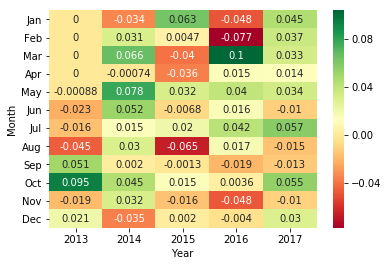

In [112]:
NIFTY_50 = benchmark_performance(start=datetime(2013,5,1),end=datetime(2018,1,1))

In [113]:
ohlc_monthly = {}
for ticker in tickers:
    ohlc_monthly[ticker]= ohlc_daily[ticker]['Adj Close'].resample('M').mean()

monthly_database = pd.DataFrame(dtype=float)
for ticker in tickers:
    monthly_database = pd.concat([monthly_database,ohlc_monthly[ticker]],axis=1)
monthly_database.columns= tickers
monthly_database= monthly_database.drop(monthly_database.index[0])

monthly_database_ret = monthly_database.pct_change()
monthly_database_ret.dropna(inplace=True)

In [114]:
def Dynamic_Portfolio_Optimizer(df,df_ret):
    dynamic_portfolio = []
    for i in range(4,len(df)):
        weights = optimal_weights(monthly_database[i-4:i])
        test_portfolio = portfolio_returns(weights,df_ret[i:i+1])
        dynamic_portfolio.append(test_portfolio['ret'])
    return dynamic_portfolio

In [116]:
Dynamic_portfolio = Dynamic_Portfolio_Optimizer(df=monthly_database,df_ret=monthly_database_ret)
Dynamic_portfolio_arr = np.array(Dynamic_portfolio)
Dynamic_portfolio_df = pd.DataFrame(Dynamic_portfolio_arr)

Dynamic_portfolio_df.columns = ['ret']
Dynamic_portfolio_df['date'] = pd.date_range(start=datetime(2013,5,1), periods=len(Dynamic_portfolio_df), freq='M ')
Dynamic_portfolio_df = Dynamic_portfolio_df.set_index('date')

In [128]:
Dynamic_portfolio_df['ret'].values

array([2013-11-30   -0.009051
Name: ret, dtype: float64,
       2013-12-31    0.078591
Name: ret, dtype: float64,
       2014-01-31   -0.044922
Name: ret, dtype: float64,
       2014-02-28   -0.130288
Name: ret, dtype: float64,
       2014-03-31    0.014772
Name: ret, dtype: float64,
       2014-04-30    0.044031
Name: ret, dtype: float64,
       2014-05-31    0.063574
Name: ret, dtype: float64,
       2014-06-30    0.052641
Name: ret, dtype: float64,
       2014-07-31   -0.034463
Name: ret, dtype: float64,
       2014-08-31    0.005873
Name: ret, dtype: float64,
       2014-09-30   -0.040076
Name: ret, dtype: float64,
       2014-10-31   -0.021993
Name: ret, dtype: float64,
       2014-11-30    0.063456
Name: ret, dtype: float64,
       2014-12-31   -0.046486
Name: ret, dtype: float64,
       2015-01-31    0.019771
Name: ret, dtype: float64,
       2015-02-28   -0.065081
Name: ret, dtype: float64,
       2015-03-31    0.016939
Name: ret, dtype: float64,
       2015-04-30   -0.032862
N

In [117]:
Dynamic_portfolio_df.head()

,ret
date,
2013-05-31,"2013-11-30 -0.009051 Name: ret, dtype: float64"
2013-06-30,"2013-12-31 0.078591 Name: ret, dtype: float64"
2013-07-31,"2014-01-31 -0.044922 Name: ret, dtype: float64"
2013-08-31,"2014-02-28 -0.130288 Name: ret, dtype: float64"
2013-09-30,"2014-03-31 0.014772 Name: ret, dtype: float64"


In [208]:
Dynamic_portfolio_perf = performance_analysis(df=Dynamic_portfolio_df['ret'],window=5,rf=0.25,leverage=1)

KeyError: 'ret'

In [24]:
Dynamic_portfolio_perf['cum_return'].plot(figsize=(15,8),grid=True)

NameError: name 'Dynamic_portfolio_perf' is not defined

# CAPM Model

In [25]:
X = Dynamic_portfolio_df['ret']
y1 = pdr.get_data_yahoo('^NSEI',start = datetime(2015,2,1), end = datetime(2019,12,1))  
y = y1['Adj Close'].resample('M').mean()

# Add a constant to the independent value
X1 = sm.add_constant(X)

# make regression model 
model = sm.OLS(y, X1)

# fit model and print results
results = model.fit()
print(results.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [26]:
print(len(X),len(y))

62 58


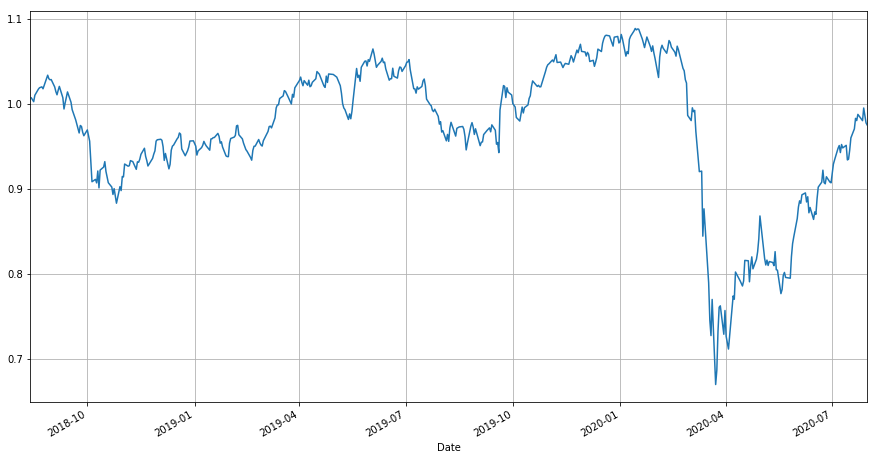

In [27]:
NIFTY_50['cum_return'].plot(figsize=(15,8),grid=True)

In [51]:
Dynamic_portfolio_perf['cum_return'].plot(figsize=(15,8),grid=True)

NameError: name 'Dynamic_portfolio_perf' is not defined

In [132]:
ohlc_daily

{'ACC.NS':                    High          Low         Open        Close    Volume  \
 Date                                                                       
 2013-05-02  1259.199951  1234.000000  1234.000000  1250.000000  228339.0   
 2013-05-03  1275.000000  1222.449951  1260.000000  1227.300049  473075.0   
 2013-05-06  1245.000000  1207.099976  1230.000000  1211.150024  243621.0   
 2013-05-07  1228.000000  1200.199951  1212.500000  1224.449951  308866.0   
 2013-05-08  1232.550049  1210.000000  1224.000000  1215.400024  269835.0   
 ...                 ...          ...          ...          ...       ...   
 2017-12-26  1744.750000  1710.500000  1721.650024  1742.099976  184518.0   
 2017-12-27  1748.000000  1725.400024  1740.150024  1735.800049  199078.0   
 2017-12-28  1757.199951  1724.800049  1737.000000  1748.650024  542581.0   
 2017-12-29  1770.000000  1747.500000  1754.900024  1758.400024  258255.0   
 2018-01-01  1763.949951  1725.000000  1763.949951  1731.349976  1

In [133]:
Close = pd.DataFrame()
for ticker in tickers:
    Close[ticker] = ohlc_daily[ticker]['Close']
    

In [134]:
Close.head()

,ACC.NS,AMBUJACEM.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BANKBARODA.NS,BHEL.NS,BPCL.NS,BHARTIARTL.NS,CIPLA.NS,...,SBIN.NS,SUNPHARMA.NS,TCS.NS,TATAMOTORS.NS,TATASTEEL.NS,TATAPOWER.NS,ULTRACEMCO.NS,VEDL.NS,WIPRO.NS,ZEEL.NS
Date,,,,,,,,,,,,,,,,,,,,,
2013-05-02,1250.000000,190.050003,472.734985,303.200012,1860.050049,142.380005,127.532997,138.949997,290.833008,409.049988,...,229.945007,483.524994,716.950012,294.194000,290.204010,91.097603,1882.650024,158.050003,132.093994,234.250000
2013-05-03,1227.300049,188.800003,469.524994,294.959991,1807.500000,139.889999,127.766998,134.432999,291.704987,400.649994,...,221.380005,492.350006,709.250000,282.569000,296.492004,90.422096,1886.300049,160.899994,133.218994,236.899994
2013-05-06,1211.150024,186.149994,485.595001,291.950012,1827.099976,140.059998,128.899994,136.149994,294.276001,405.049988,...,222.610001,491.075012,733.599976,287.960999,307.304993,90.711601,1911.500000,164.250000,134.005997,239.500000
2013-05-07,1224.449951,185.250000,490.000000,300.790009,1848.449951,140.979996,131.067001,135.567001,304.101013,408.049988,...,225.679993,495.475006,735.799988,295.233002,309.354004,90.904602,1928.550049,164.050003,131.550003,234.699997
2013-05-08,1215.400024,184.050003,485.355011,297.940002,1838.650024,138.419998,130.233002,136.449997,297.673004,406.049988,...,225.470001,492.774994,740.049988,297.063995,303.589996,90.663399,1978.199951,164.699997,131.643997,245.699997


In [137]:
Returns = pd.DataFrame()
Returns = Close.pct_change()

In [138]:
Returns

,ACC.NS,AMBUJACEM.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BANKBARODA.NS,BHEL.NS,BPCL.NS,BHARTIARTL.NS,CIPLA.NS,...,SBIN.NS,SUNPHARMA.NS,TCS.NS,TATAMOTORS.NS,TATASTEEL.NS,TATAPOWER.NS,ULTRACEMCO.NS,VEDL.NS,WIPRO.NS,ZEEL.NS
Date,,,,,,,,,,,,,,,,,,,,,
2013-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-03,-0.018160,-0.006577,-0.006790,-0.027177,-0.028252,-0.017488,0.001835,-0.032508,0.002998,-0.020535,...,-0.037248,0.018251,-0.010740,-0.039515,0.021667,-0.007415,0.001939,0.018032,0.008517,0.011313
2013-05-06,-0.013159,-0.014036,0.034226,-0.010205,0.010844,0.001215,0.008868,0.012772,0.008814,0.010982,...,0.005556,-0.002590,0.034332,0.019082,0.036470,0.003202,0.013359,0.020820,0.005908,0.010975
2013-05-07,0.010981,-0.004835,0.009071,0.030279,0.011685,0.006569,0.016812,-0.004282,0.033387,0.007406,...,0.013791,0.008960,0.002999,0.025253,0.006668,0.002128,0.008920,-0.001218,-0.018327,-0.020042
2013-05-08,-0.007391,-0.006478,-0.009480,-0.009475,-0.005302,-0.018159,-0.006363,0.006513,-0.021138,-0.004901,...,-0.000930,-0.005449,0.005776,0.006202,-0.018632,-0.002653,0.025745,0.003962,0.000715,0.046868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-26,0.011878,0.021300,0.011204,0.002529,0.012031,-0.008929,0.008677,0.007007,0.027245,0.017548,...,-0.008441,0.019493,0.001013,0.005213,0.014693,0.004313,0.011996,0.017059,0.004310,0.012793
2017-12-27,-0.003616,-0.007318,-0.001477,-0.000721,-0.008890,-0.003003,-0.003763,-0.010206,-0.015287,0.001471,...,-0.007252,0.064659,-0.011150,-0.004125,0.002494,-0.009125,-0.014434,0.013201,0.012215,0.009366
2017-12-28,0.007403,0.001106,-0.004047,-0.013974,-0.013147,-0.019578,-0.005397,-0.013498,-0.006172,-0.010773,...,-0.020486,-0.013708,0.002687,-0.009114,0.017693,-0.002709,-0.000292,0.019926,0.004566,-0.002554


In [140]:
weights2 = optimal_weights(Close)
weights2

array([5.03975613e-17, 5.78121673e-16, 6.28552797e-16, 0.00000000e+00,
       9.03873686e-16, 4.20921744e-16, 1.95912853e-15, 9.84418968e-02,
       1.37359912e-15, 5.92844851e-16, 4.73533908e-16, 1.10103488e-15,
       1.46774387e-15, 8.36000796e-16, 1.24466068e-15, 1.33822499e-01,
       6.48703999e-02, 9.80087938e-16, 6.38732097e-16, 1.22030607e-01,
       1.73704194e-02, 6.01133899e-16, 2.53405880e-16, 8.09535450e-16,
       1.33840701e-15, 2.39710848e-02, 7.56137143e-02, 3.54421093e-15,
       1.14554116e-02, 0.00000000e+00, 1.01481784e-15, 1.03330365e-16,
       3.55329106e-01, 5.26916956e-16, 3.06496362e-16, 5.00579737e-16,
       2.39315861e-16, 1.08168222e-15, 8.07206489e-16, 9.65338781e-16,
       3.84929467e-16, 8.58145302e-16, 4.09870141e-02, 4.86382613e-16,
       5.61013731e-17, 4.76162708e-16, 7.55537742e-16, 0.00000000e+00,
       5.02129707e-02, 5.89487746e-03])

In [142]:
np.sum(weights2*Returns,axis = 1)

Date
2013-05-02    0.000000
2013-05-03   -0.003428
2013-05-06    0.009633
2013-05-07    0.002306
2013-05-08    0.000286
                ...   
2017-12-26    0.000297
2017-12-27   -0.003468
2017-12-28   -0.000016
2017-12-29    0.007110
2018-01-01   -0.011249
Length: 1151, dtype: float64

In [143]:
start2= datetime(2018,1,3)
end2 = datetime.today()

ohlc_daily2  = {}

for i in range(len(tickers)):
    ohlc_daily2[tickers[i]] = pdr.get_data_yahoo(tickers[i],start = start2 , end = end2)


In [144]:
Close2 = pd.DataFrame()
for ticker in tickers:
    Close2[ticker] = ohlc_daily2[ticker]['Close']

In [146]:
Close2.tail()

,ACC.NS,AMBUJACEM.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BANKBARODA.NS,BHEL.NS,BPCL.NS,BHARTIARTL.NS,CIPLA.NS,...,SBIN.NS,SUNPHARMA.NS,TCS.NS,TATAMOTORS.NS,TATASTEEL.NS,TATAPOWER.NS,ULTRACEMCO.NS,VEDL.NS,WIPRO.NS,ZEEL.NS
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-03,1414.099976,221.149994,1705.500000,417.350006,2917.449951,46.849998,36.200001,417.799988,547.349976,710.400024,...,192.250000,519.400024,2254.149902,113.050003,373.500000,48.750000,4045.550049,115.300003,281.549988,134.949997
2020-08-04,1401.449951,221.550003,1713.949951,429.149994,2969.949951,46.500000,36.650002,408.549988,549.000000,713.849976,...,191.600006,528.950012,2249.699951,111.449997,372.250000,49.700001,4004.300049,119.050003,281.049988,143.350006
2020-08-05,1411.900024,220.899994,1716.300049,434.950012,3009.000000,46.349998,36.700001,410.450012,558.950012,722.150024,...,191.449997,528.849976,2259.500000,115.400002,395.799988,48.950001,4041.050049,121.949997,278.200012,145.550003
2020-08-06,1406.199951,222.949997,1727.550049,433.000000,2991.800049,46.250000,35.700001,409.549988,555.299988,731.099976,...,190.949997,532.250000,2308.100098,116.800003,400.450012,49.400002,4028.350098,122.750000,279.649994,148.750000
2020-08-07,1397.199951,219.550003,1806.250000,433.299988,3001.699951,48.349998,35.250000,419.750000,560.799988,728.650024,...,190.649994,525.950012,2295.350098,119.099998,404.049988,49.700001,4004.250000,122.800003,277.399994,150.100006


In [147]:
Returns2 = pd.DataFrame()
Returns2 = Close2.pct_change()

In [148]:
Returns2

,ACC.NS,AMBUJACEM.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BANKBARODA.NS,BHEL.NS,BPCL.NS,BHARTIARTL.NS,CIPLA.NS,...,SBIN.NS,SUNPHARMA.NS,TCS.NS,TATAMOTORS.NS,TATASTEEL.NS,TATAPOWER.NS,ULTRACEMCO.NS,VEDL.NS,WIPRO.NS,ZEEL.NS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,0.015074,0.003118,0.026403,-0.000981,0.007220,0.038327,0.022324,-0.006870,0.009262,0.016398,...,0.018656,0.021351,0.006996,-0.009103,0.034424,-0.011905,0.010123,0.019850,0.005485,0.000431
2018-01-05,0.004774,0.001646,0.011262,0.005983,0.004718,-0.012813,0.015881,-0.007731,0.032505,-0.002594,...,-0.006969,-0.004215,0.012081,0.003838,0.013745,-0.000502,0.011575,0.001327,-0.006738,0.011810
2018-01-08,0.008315,0.002556,-0.002742,0.003906,-0.001250,-0.000927,-0.003908,0.019479,-0.043796,-0.000163,...,-0.001795,0.022203,0.009371,0.004518,-0.002530,0.003014,0.006711,0.002062,0.005169,0.012013
2018-01-09,-0.007096,0.009286,0.009349,-0.000265,-0.009845,0.017631,-0.008337,-0.002212,-0.012685,0.000894,...,-0.004905,-0.008621,-0.001989,0.009226,0.004619,-0.012519,0.000350,-0.007494,0.019442,-0.023320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-03,-0.007962,0.004771,-0.005829,-0.033129,-0.029119,0.001068,0.006954,0.009667,-0.013517,-0.013539,...,0.004179,-0.023133,-0.011944,0.080268,0.019656,0.001027,-0.017426,0.013181,0.002136,-0.027387
2020-08-04,-0.008946,0.001809,0.004955,0.028274,0.017995,-0.007471,0.012431,-0.022140,0.003015,0.004856,...,-0.003381,0.018387,-0.001974,-0.014153,-0.003347,0.019487,-0.010196,0.032524,-0.001776,0.062245
2020-08-05,0.007457,-0.002934,0.001371,0.013515,0.013148,-0.003226,0.001364,0.004651,0.018124,0.011627,...,-0.000783,-0.000189,0.004356,0.035442,0.063264,-0.015091,0.009178,0.024359,-0.010140,0.015347


In [171]:
Portreturns = pd.DataFrame(index = Returns2.index ,columns = ['ret'])
Portreturns['ret'] = np.sum(weights2*Returns2,axis = 1)
Portreturns




,ret
Date,
2018-01-03,0.000000
2018-01-04,0.000810
2018-01-05,0.005169
2018-01-08,0.005231
2018-01-09,-0.003857
...,...
2020-08-03,-0.008231
2020-08-04,0.011818
2020-08-05,0.009939


                       0
Cumm_Return    10.897417
Annual_Return   4.183528
Volatility      0.244158
Sharpe Ratio    0.048474
Max Drawdown   36.087144


,ret,cum_return,rolling_volatility,rolling_sharpe,cum_roll_max,drawdown,drawdown_pct,Year,Month
Date,,,,,,,,,
2018-01-03,0.000000,1.000000,NaN,NaN,1.000000,0.000000,0.000000,2018,Jan
2018-01-04,0.000810,1.000810,NaN,NaN,1.000810,0.000000,0.000000,2018,Jan
2018-01-05,0.005169,1.005983,NaN,NaN,1.005983,0.000000,0.000000,2018,Jan
2018-01-08,0.005231,1.011245,NaN,NaN,1.011245,0.000000,0.000000,2018,Jan
2018-01-09,-0.003857,1.007345,0.003834,0.857686,1.011245,0.003900,0.003857,2018,Jan
...,...,...,...,...,...,...,...,...,...
2020-08-03,-0.008231,1.068669,0.015253,0.028382,1.126017,0.057348,0.050930,2020,Aug
2020-08-04,0.011818,1.081298,0.009485,-0.622737,1.126017,0.044718,0.039714,2020,Aug
2020-08-05,0.009939,1.092046,0.009025,0.447841,1.126017,0.033971,0.030169,2020,Aug


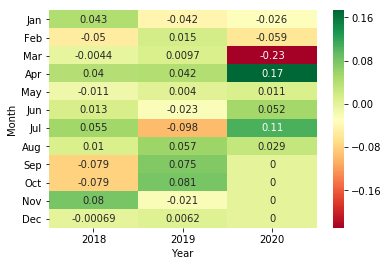

In [172]:
performance_analysis(Portreturns,5,0.03,1)

In [174]:
NIFTY = pd.DataFrame()
NIFTY = pdr.get_data_yahoo('^NSEI',start = start2, end = end2)
NIFTY

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-03,10503.599609,10429.549805,10482.650391,10443.200195,167300.0,10443.200195
2018-01-04,10513.000000,10441.450195,10469.400391,10504.799805,174900.0,10504.799805
2018-01-05,10566.099609,10520.099609,10534.250000,10558.849609,180900.0,10558.849609
2018-01-08,10631.200195,10588.549805,10591.700195,10623.599609,169000.0,10623.599609
2018-01-09,10659.150391,10603.599609,10645.099609,10637.000000,205000.0,10637.000000
...,...,...,...,...,...,...
2020-08-03,11058.049805,10882.250000,11057.549805,10891.599609,680900.0,10891.599609
2020-08-04,11112.250000,10908.099609,10946.650391,11095.250000,625700.0,11095.250000
2020-08-05,11225.650391,11064.049805,11155.750000,11101.650391,667600.0,11101.650391


In [175]:
Niftyclose = NIFTY['Close']
Niftyclose.head()

Date
2018-01-03    10443.200195
2018-01-04    10504.799805
2018-01-05    10558.849609
2018-01-08    10623.599609
2018-01-09    10637.000000
Name: Close, dtype: float64

In [179]:
Niftyret = pd.DataFrame( index = Returns2.index ,columns = ['ret'])
Niftyret['ret'] = Niftyclose.pct_change()
Niftyret.head()

,ret
Date,
2018-01-03,NaN
2018-01-04,0.005899
2018-01-05,0.005145
2018-01-08,0.006132
2018-01-09,0.001261


                       0
Cumm_Return     7.381354
Annual_Return   2.861970
Volatility      0.220061
Sharpe Ratio   -0.006272
Max Drawdown   38.439852


,ret,cum_return,rolling_volatility,rolling_sharpe,cum_roll_max,drawdown,drawdown_pct,Year,Month
Date,,,,,,,,,
2018-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,Jan
2018-01-04,0.005899,1.005899,NaN,NaN,1.005899,0.000000,0.000000,2018,Jan
2018-01-05,0.005145,1.011074,NaN,NaN,1.011074,0.000000,0.000000,2018,Jan
2018-01-08,0.006132,1.017274,NaN,NaN,1.017274,0.000000,0.000000,2018,Jan
2018-01-09,0.001261,1.018558,NaN,NaN,1.018558,0.000000,0.000000,2018,Jan
...,...,...,...,...,...,...,...,...,...
2020-08-03,-0.016422,1.042937,0.011931,-0.805213,1.183765,0.140828,0.118967,2020,Aug
2020-08-04,0.018698,1.062438,0.013390,-0.599318,1.183765,0.121328,0.102493,2020,Aug
2020-08-05,0.000577,1.063051,0.013152,-0.296552,1.183765,0.120715,0.101975,2020,Aug


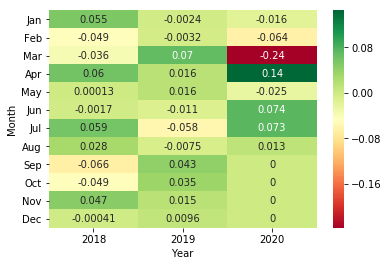

In [180]:
performance_analysis(Niftyret,5,0.03,1)

In [197]:
def minvar_weights(df):
    mu = expected_returns.mean_historical_return(df)
    S = risk_models.sample_cov(df)
    ef = EfficientFrontier(mu, S,weight_bounds=(0, 1))
    raw_weights = ef.min_volatility()
    raw_weights = list(raw_weights.values())
    weights = np.array(raw_weights)
    return weights

In [198]:
min_variance_wt = minvar_weights(Close)
min_variance_wt

array([1.74538958e-02, 0.00000000e+00, 1.51173612e-03, 0.00000000e+00,
       2.18697274e-02, 0.00000000e+00, 0.00000000e+00, 4.13988604e-04,
       2.90824802e-02, 3.76623785e-02, 4.84829283e-02, 5.12504562e-02,
       0.00000000e+00, 1.15833528e-02, 1.04028245e-02, 3.50773122e-02,
       5.31349244e-02, 2.37631957e-02, 0.00000000e+00, 1.14628624e-01,
       4.72985182e-02, 0.00000000e+00, 4.15861152e-02, 0.00000000e+00,
       6.49843677e-18, 6.19603589e-02, 0.00000000e+00, 1.41759434e-17,
       1.44334414e-18, 4.25549353e-18, 5.28164872e-02, 1.07827591e-02,
       2.00298385e-02, 2.02529534e-02, 6.38173601e-03, 4.67562187e-18,
       1.09775470e-18, 1.04470570e-01, 6.74807107e-04, 0.00000000e+00,
       0.00000000e+00, 4.93528571e-03, 6.71113962e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.45388994e-20, 3.30681663e-18,
       1.05381349e-01, 0.00000000e+00])

In [199]:
Min_var_returns = pd.DataFrame(index = Returns2.index ,columns = ['ret'])
Min_var_returns['ret'] = np.sum(min_variance_wt*Returns2,axis = 1)
Min_var_returns

,ret
Date,
2018-01-03,0.000000
2018-01-04,0.005035
2018-01-05,0.006463
2018-01-08,0.006442
2018-01-09,0.003684
...,...
2020-08-03,-0.007746
2020-08-04,0.005408
2020-08-05,-0.002687


                       0
Cumm_Return    20.842211
Annual_Return   7.789686
Volatility      0.173221
Sharpe Ratio    0.276508
Max Drawdown   27.678566


,ret,cum_return,rolling_volatility,rolling_sharpe,cum_roll_max,drawdown,drawdown_pct,Year,Month
Date,,,,,,,,,
2018-01-03,0.000000,1.000000,NaN,NaN,1.000000,0.000000,0.000000,2018,Jan
2018-01-04,0.005035,1.005035,NaN,NaN,1.005035,0.000000,0.000000,2018,Jan
2018-01-05,0.006463,1.011530,NaN,NaN,1.011530,0.000000,0.000000,2018,Jan
2018-01-08,0.006442,1.018046,NaN,NaN,1.018046,0.000000,0.000000,2018,Jan
2018-01-09,0.003684,1.021796,0.002677,3.611860,1.021796,0.000000,0.000000,2018,Jan
...,...,...,...,...,...,...,...,...,...
2020-08-03,-0.007746,1.202269,0.008752,0.563128,1.211654,0.009385,0.007746,2020,Aug
2020-08-04,0.005408,1.208770,0.005342,0.063211,1.211654,0.002884,0.002380,2020,Aug
2020-08-05,-0.002687,1.205522,0.005411,-0.279443,1.211654,0.006132,0.005061,2020,Aug


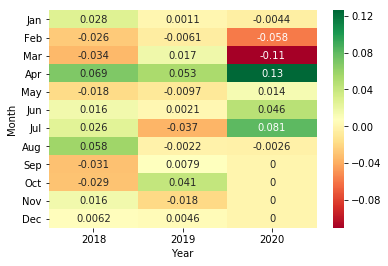

In [200]:
performance_analysis(Min_var_returns,5,0.03,1)

In [202]:
eqwt = np.zeros(50)
for i in range(0,50):
    eqwt[i] = 1/50

In [203]:
eqwt

array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02])

In [207]:
Eqw_returns = pd.DataFrame(index = Returns2.index ,columns = ['ret'])
Eqw_returns['ret'] = np.sum(eqwt*Returns2,axis = 1)
Eqw_returns

,ret
Date,
2018-01-03,0.000000
2018-01-04,0.010832
2018-01-05,0.007752
2018-01-08,0.005502
2018-01-09,-0.001808
...,...
2020-08-03,-0.005261
2020-08-04,0.009289
2020-08-05,0.008361


                       0
Cumm_Return   -21.171954
Annual_Return  -8.995643
Volatility      0.227191
Sharpe Ratio   -0.527999
Max Drawdown   49.810640


,ret,cum_return,rolling_volatility,rolling_sharpe,cum_roll_max,drawdown,drawdown_pct,Year,Month
Date,,,,,,,,,
2018-01-03,0.000000,1.000000,NaN,NaN,1.000000,0.000000,0.000000,2018,Jan
2018-01-04,0.010832,1.010832,NaN,NaN,1.010832,0.000000,0.000000,2018,Jan
2018-01-05,0.007752,1.018668,NaN,NaN,1.018668,0.000000,0.000000,2018,Jan
2018-01-08,0.005502,1.024273,NaN,NaN,1.024273,0.000000,0.000000,2018,Jan
2018-01-09,-0.001808,1.022421,0.005285,1.885256,1.024273,0.001852,0.001808,2018,Jan
...,...,...,...,...,...,...,...,...,...
2020-08-03,-0.005261,0.768986,0.010974,0.476887,1.033697,0.264711,0.256082,2020,Aug
2020-08-04,0.009289,0.776129,0.008207,0.162759,1.033697,0.257568,0.249172,2020,Aug
2020-08-05,0.008361,0.782618,0.008739,0.308085,1.033697,0.251079,0.242895,2020,Aug


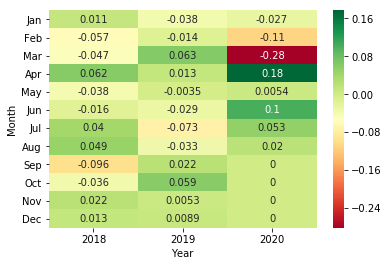

In [205]:
performance_analysis(Eqw_returns,5,0.03,1)